In [ ]:
# Data Verification and Spatial Processing for Irrigation and Dam Command Areas in Sub-Saharan Africa
# This notebook prepares and verifies geospatial data to compare irrigation distributions inside and outside dam command areas, following advisor feedback. Each step is clearly documented and outputs are printed for verification.

# **Outline:**
# 1. Import Required Libraries
# 2. Load Geospatial Datasets
# 3. Inspect and Harmonize Coordinate Reference Systems (CRS)
# 4. Check and Process Command Area Overlaps
# 5. Define Study Area and Generate Inside/Outside Polygons
# 6. Extract Irrigation Pixel Values for Inside and Outside Regions
# 7. Save Extracted Pixel Values to CSV
# 8. Visualize Command Areas and Study Domain
# 9. Visualize Sampled Irrigation Data Extraction

import geopandas as gpd
import rasterio
from rasterio.crs import CRS
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pyproj
from shapely.geometry import box, mapping
from shapely.ops import unary_union, transform
from shapely.strtree import STRtree
import shutil
import tempfile
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Load configuration
config = load_config()

# --- Load Geospatial Datasets using utility functions ---
# Load data using utility functions and resolved paths
cpis = load_and_reproject(resolve_path(config['SSA_Combined_CPIS_All_shp_path']), target_crs="EPSG:3857")
dams = load_and_reproject(resolve_path(config['AridAfrica_Barriers_shp_path']), target_crs="EPSG:3857")
ca = load_and_reproject(resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path']), target_crs="EPSG:3857")
ca_init = load_and_reproject(resolve_path(config['No_Crop_Initial_CA_shp_path']), target_crs="EPSG:3857")
irrig_raster_2000_path = resolve_path(config['Africa_AEI_2000_asc_path'])
irrig_raster_2015_path = resolve_path(config['Africa_AEI_2015_asc_path'])
ssa_arid_shp_fp = resolve_path(config['SSA_Arid_by_Country_shp_path'])

print('CPIS CRS:', cpis.crs)
print(cpis.head())
print('Dams CRS:', dams.crs)
print(dams.head())
print('Command Areas CRS:', ca.crs)
print(ca.head())
print('Initial Command Areas CRS:', ca_init.crs)
print(ca_init.head())

# Load irrigation rasters
with rasterio.open(irrig_raster_2000_path) as src:
    irrigation_2000_meta = src.meta
    print('Irrigation 2000 raster meta:', irrigation_2000_meta)
with rasterio.open(irrig_raster_2015_path) as src:
    irrigation_2015_meta = src.meta
    print('Irrigation 2015 raster meta:', irrigation_2015_meta)


OGC:CRS84
CPIS CRS: EPSG:3857
   ID       Country Country Co  Year  \
0   1  South Africa        ZAF  2000   
1   2  South Africa        ZAF  2000   
2   3  South Africa        ZAF  2000   
3   4  South Africa        ZAF  2000   
4   5  South Africa        ZAF  2000   

                                            geometry  
0  POLYGON ((2158598.021 -4057555.506, 2158658.42...  
1  POLYGON ((2158740.433 -4056950.848, 2158788.75...  
2  POLYGON ((2286656.768 -4053677.724, 2286693.00...  
3  POLYGON ((2285644.300 -4053175.531, 2285704.69...  
4  POLYGON ((2184297.066 -4052314.792, 2184333.29...  
Dams CRS: EPSG:3857
  USE_OTHR  DOR_PC                        DATA_INFO  HYLAK_ID LAKE_CTRL  \
0     None    64.5  Capacity from statistics - Eq 2      1633      None   
1     None    12.3                             None   1427712      None   
2     None   475.6  Capacity from statistics - Eq 2   1418948      None   
3     None   887.9  Capacity from statistics - Eq 2   1423685      None   
4   

In [ ]:

# --- Inspect and Harmonize Coordinate Reference Systems (CRS) ---
# All vectors are loaded as EPSG:3857 by utility, so CRS should match
print('All vector datasets should be loaded in EPSG:3857.')

# Check raster CRS
print('Irrigation 2000 raster CRS:', irrigation_2000_meta['crs'])
print('Irrigation 2015 raster CRS:', irrigation_2015_meta['crs'])
if irrigation_2000_meta['crs'] != ca.crs:
    print('Raster CRS does not match vector CRS. Recommend using rasterio.warp.reproject to reproject raster to EPSG:3857.')
if irrigation_2015_meta['crs'] != ca.crs:
    print('Raster CRS does not match vector CRS. Recommend using rasterio.warp.reproject to reproject raster to EPSG:3857.')

# --- Ensure Irrigation Rasters Have Accurate CRS ---
def force_assign_crs_3857(raster_path):
    correct_crs = CRS.from_epsg(3857)
    with rasterio.open(raster_path, 'r+') as src:
        print(f'Original (wrong) CRS: {src.crs}')
        src.crs = correct_crs
        print(f'New (forced) CRS: {src.crs}')

force_assign_crs_3857(irrig_raster_2000_path)
force_assign_crs_3857(irrig_raster_2015_path)


In [2]:

# --- Check and Process Vectorized Command Area Overlaps (networkx-based merge) ---

# Build an undirected graph where nodes are polygon indices, edges mean overlap
G = nx.Graph()
G.add_nodes_from(range(len(ca)))
for i, geom1 in enumerate(ca.geometry):
    for j in range(i+1, len(ca)):
        geom2 = ca.geometry.iloc[j]
        if geom1.intersects(geom2):
            G.add_edge(i, j)

# Find connected components (groups of overlapping polygons)
groups = list(nx.connected_components(G))

# Merge polygons in each group
merged_geoms = []
n_merged = []
merged_gdw_ids = []
for group in groups:
    group_indices = list(group)
    group_df = ca.iloc[group_indices]
    merged_geom = unary_union(group_df.geometry)
    merged_geoms.append(merged_geom)
    n_merged.append(len(group_df))
    merged_gdw_ids.append(list(group_df['GDW_ID']))

CA_No_Overlap = gpd.GeoDataFrame({
    'geometry': merged_geoms,
    'n_merged': n_merged,
    'merged_GDW_IDs': [",".join(map(str, ids)) for ids in merged_gdw_ids]
}, crs=ca.crs)

print(f"Created {len(CA_No_Overlap)} non-overlapping command areas.")
print(CA_No_Overlap.head())

# Test for Overlaps in CA_No_Overlap
geoms = list(CA_No_Overlap.geometry)
tree = STRtree(geoms)
overlap_found = False
for i, geom in enumerate(geoms):
    matches = [j for j, other in enumerate(geoms) if i != j and geom.intersects(other)]
    if matches:
        overlap_found = True
        print(f"Overlap found for geometry {i} (overlaps with: {matches})")
        break
if overlap_found:
    print('Overlaps detected in CA_No_Overlap!')
else:
    print('No overlaps detected in CA_No_Overlap.')
    # Save CA_No_Overlap as a shapefile
    output_path = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])
    CA_No_Overlap.to_file(output_path, driver='ESRI Shapefile')
    print(f"Saved non-overlapping command areas to: {output_path}")


Created 164 non-overlapping command areas.
                                            geometry  n_merged  merged_GDW_IDs
0  MULTIPOLYGON (((3535320.000 -3095300.089, 3535...         1            7072
1  MULTIPOLYGON (((3339930.000 -2864750.960, 3339...         1            7250
2  MULTIPOLYGON (((3346500.000 -2607888.501, 3346...         3  2034,6667,5322
3  MULTIPOLYGON (((4440270.000 1022430.957, 44402...         1            6910
4  MULTIPOLYGON (((-515460.000 1266440.673, -5154...         1            6895
No overlaps detected in CA_No_Overlap.
Saved non-overlapping command areas to: /home/waves/data/Africa_Irrigation/Data/Processed/No_Crop_Vectorized_UniLayer_CA-shp


In [ ]:

# # --- Check and Process Initial Command Area Overlaps (networkx-based merge) ---

# # Build an undirected graph where nodes are polygon indices, edges mean overlap
# G = nx.Graph()
# G.add_nodes_from(range(len(ca_init)))
# for i, geom1 in enumerate(ca_init.geometry):
#     for j in range(i+1, len(ca_init)):
#         geom2 = ca_init.geometry.iloc[j]
#         if geom1.intersects(geom2):
#             G.add_edge(i, j)

# # Find connected components (groups of overlapping polygons)
# groups = list(nx.connected_components(G))

# # Merge polygons in each group
# merged_geoms = []
# n_merged = []
# merged_gdw_ids = []
# for group in groups:
#     group_indices = list(group)
#     group_df = ca_init.iloc[group_indices]
#     merged_geom = unary_union(group_df.geometry)
#     merged_geoms.append(merged_geom)
#     n_merged.append(len(group_df))
#     merged_gdw_ids.append(list(group_df['GDW_ID']))

# CA_Init_No_Overlap = gpd.GeoDataFrame({
#     'geometry': merged_geoms,
#     'n_merged': n_merged,
#     'merged_GDW_IDs': [",".join(map(str, ids)) for ids in merged_gdw_ids]
# }, crs=ca_init.crs)

# print(f"Created {len(CA_Init_No_Overlap)} non-overlapping command areas.")
# print(CA_Init_No_Overlap.head())

# # Test for Overlaps in CA_Init_No_Overlap
# geoms = list(CA_Init_No_Overlap.geometry)
# tree = STRtree(geoms)
# overlap_found = False
# for i, geom in enumerate(geoms):
#     matches = [j for j, other in enumerate(geoms) if i != j and geom.intersects(other)]
#     if matches:
#         overlap_found = True
#         print(f"Overlap found for geometry {i} (overlaps with: {matches})")
#         break
# if overlap_found:
#     print('Overlaps detected in CA_Init_No_Overlap!')
# else:
#     print('No overlaps detected in CA_Init_No_Overlap.')
#     # Save CA_Init_No_Overlap as a shapefile
#     output_path = resolve_path(config['No_Crop_Initial_CA_UniLayer_shp_path'])
#     CA_Init_No_Overlap.to_file(output_path, driver='ESRI Shapefile')
#     print(f"Saved non-overlapping command areas to: {output_path}")


In [3]:
# --- Define Study Area and Generate Inside/Outside Polygons ---
# Use SSA arid shapefile as study area boundary (or raster bounds if not available)
if os.path.exists(ssa_arid_shp_fp):
    study_area = load_and_reproject(ssa_arid_shp_fp, target_crs="EPSG:3857")
    study_area_union = unary_union(study_area.geometry)
else:
    # Use raster bounds as fallback
    bounds = rasterio.open(irrig_raster_2000_path).bounds
    study_area_union = box(*bounds)
    study_area = gpd.GeoDataFrame({'geometry': [study_area_union]}, crs=ca.crs)

# Create outside area by subtracting total_command_area from study_area
inside_geom = CA_No_Overlap.geometry.unary_union
outside_geom = study_area_union.difference(inside_geom)
total_outside_area = gpd.GeoDataFrame({'geometry': [outside_geom]}, crs=ca.crs) # Everything that is not a CA

print('Study area and inside/outside polygons defined.')


Study area and inside/outside polygons defined.


In [4]:
# --- Extract Irrigation Pixel Values for Inside and Outside Regions ---
def extract_pixels(raster_fp, mask_geom):
    with rasterio.open(raster_fp) as src:
        # Assume CRS is now set and matches expected
        out_image, out_transform = rasterio.mask.mask(src, [mapping(mask_geom)], crop=False, filled=True)
        arr = out_image[0]
        mask = arr != src.nodata
        values = arr[mask]
        return values

# Extract for 2000
inside_pixels_2000 = extract_pixels(irrig_raster_2000_path, inside_geom)
print(f'Extracted {len(inside_pixels_2000)} pixels for inside region in 2000.')
outside_pixels_2000 = extract_pixels(irrig_raster_2000_path, outside_geom)
# Extract for 2015
inside_pixels_2015 = extract_pixels(irrig_raster_2015_path, inside_geom)
outside_pixels_2015 = extract_pixels(irrig_raster_2015_path, outside_geom)

print('Extracted pixel values for inside/outside, 2000/2015.')

# --- Organize Extracted Pixel Values into DataFrames for Analysis ---
# Create informative DataFrames for each region and year
df_inside_2000 = pd.DataFrame({'region': 'inside', 'year': 2000, 'irrigation_value': inside_pixels_2000})
print('Inside 2000 irrigation pixel values:', df_inside_2000.head())
df_outside_2000 = pd.DataFrame({'region': 'outside', 'year': 2000, 'irrigation_value': outside_pixels_2000})
print('Outside 2000 irrigation pixel values:', df_outside_2000.head())
df_inside_2015 = pd.DataFrame({'region': 'inside', 'year': 2015, 'irrigation_value': inside_pixels_2015})
print('Inside 2015 irrigation pixel values:', df_inside_2015.head())
df_outside_2015 = pd.DataFrame({'region': 'outside', 'year': 2015, 'irrigation_value': outside_pixels_2015})
print('Outside 2015 irrigation pixel values:', df_outside_2015.head())

df_inside_2000['irrigation_value'].to_csv(resolve_path(config['Irrigation_Inside_CA_2000_csv_path']), index=False)
df_outside_2000['irrigation_value'].to_csv(resolve_path(config['Irrigation_Outside_CA_2000_csv_path']), index=False)
df_inside_2015['irrigation_value'].to_csv(resolve_path(config['Irrigation_Inside_CA_2015_csv_path']), index=False)
df_outside_2015['irrigation_value'].to_csv(resolve_path(config['Irrigation_Outside_CA_2015_csv_path']), index=False)
print("Saved all irrigation pixel value DataFrames to CSV using resolve_path.")

# Combine all into a single DataFrame for easier analysis
df_irrigation = pd.concat([df_inside_2000, df_outside_2000, df_inside_2015, df_outside_2015], ignore_index=True)

print('Created irrigation pixel value DataFrames:')
print(df_irrigation.groupby(['region', 'year']).size())


Extracted 7 pixels for inside region in 2000.
Extracted pixel values for inside/outside, 2000/2015.
Inside 2000 irrigation pixel values:    region  year  irrigation_value
0  inside  2000          0.000000
1  inside  2000          0.000000
2  inside  2000        863.864014
3  inside  2000          0.000000
4  inside  2000       4414.440918
Outside 2000 irrigation pixel values:     region  year  irrigation_value
0  outside  2000               0.0
1  outside  2000               0.0
2  outside  2000               0.0
3  outside  2000               0.0
4  outside  2000               0.0
Inside 2015 irrigation pixel values:    region  year  irrigation_value
0  inside  2015          0.000000
1  inside  2015          0.000000
2  inside  2015        863.864014
3  inside  2015          0.000000
4  inside  2015       2478.623779
Outside 2015 irrigation pixel values:     region  year  irrigation_value
0  outside  2015               0.0
1  outside  2015               0.0
2  outside  2015           

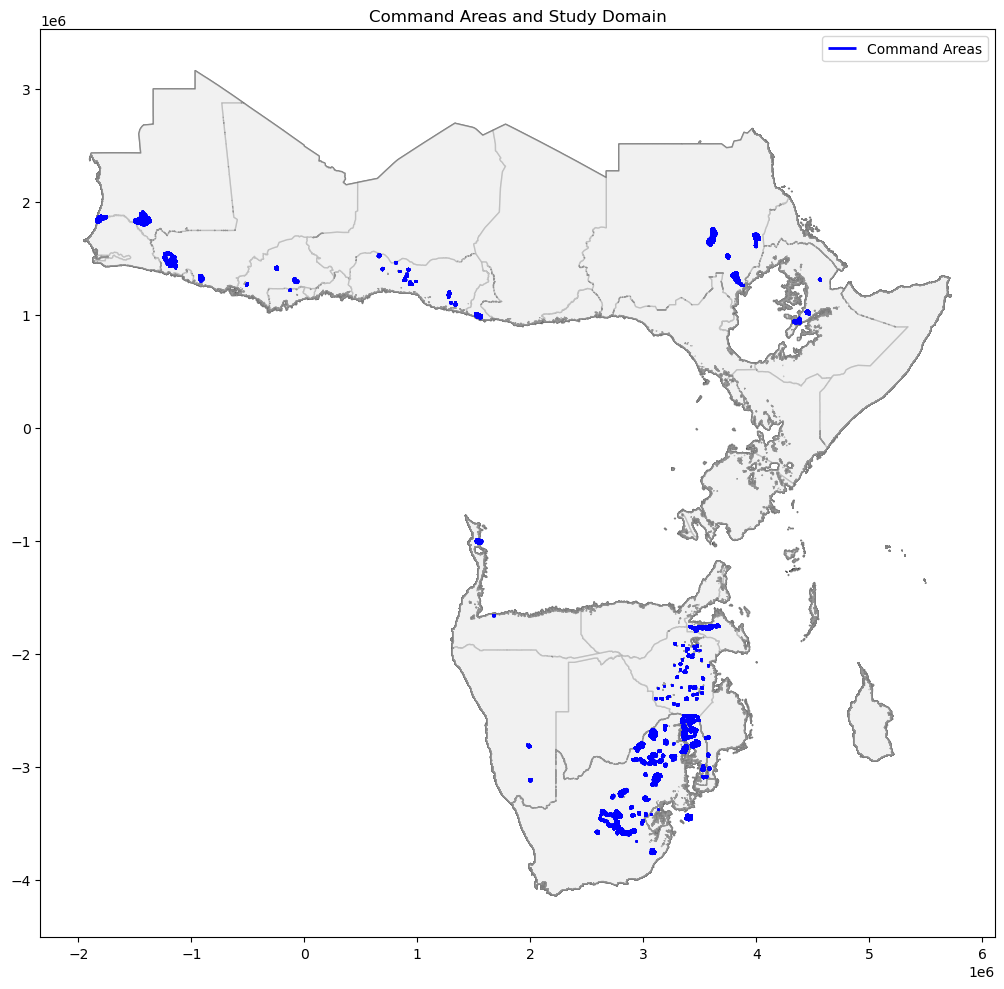

--- Debug Info: Geometry and Raster ---
Raster CRS: OGC:CRS84
CA_No_Overlap CRS: EPSG:3857
Inside geom type: <class 'shapely.geometry.multipolygon.MultiPolygon'>
Inside geom bounds: (-1837770.0, -3768165.4521756647, 4568310.0, 1912480.6092117853)
Outside geom type: <class 'shapely.geometry.multipolygon.MultiPolygon'>
Outside geom bounds: (-1952729.401722066, -4141254.804497289, 5723569.007380844, 3160761.3823334817)
Raster bounds: BoundingBox(left=-20037508.342789244, bottom=-242578414.5395433, right=19968207.674423996, top=242528680.94374272)
Raster shape: (4814, 398)
Raster nodata: -9.0


In [ ]:
# --- Visualize Command Areas and Study Domain ---
# Ensure irrigation raster CRS is forced to EPSG:3857 before visualization
force_assign_crs_3857(irrig_raster_2015_path)

fig, ax = plt.subplots(figsize=(12, 10))
print('CRS check:')
print('Study area CRS:', study_area.crs)
print('Total outside area CRS:', total_outside_area.crs)
print('CA_No_Overlap CRS:', CA_No_Overlap.crs)
with rasterio.open(irrig_raster_2015_path) as src:
    print('Irrigation raster CRS:', src.crs)

if os.path.exists(ssa_arid_shp_fp):
    study_area.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Study Area')
total_outside_area.plot(ax=ax, color='whitesmoke', edgecolor='gray', alpha=0.7, label='Outside Area')
CA_No_Overlap.boundary.plot(ax=ax, color='blue', linewidth=2, label='Command Areas')
plt.title('Command Areas and Study Domain')
plt.legend()
plt.tight_layout()
#plt.savefig('command_areas_study_domain.png', dpi=300)
plt.show()
#print('Saved map: command_areas_study_domain.png')

# --- Debug: Print geometry and raster info before pixel sampling ---
print('--- Debug Info: Geometry and Raster ---')
with rasterio.open(irrig_raster_2015_path) as src:
    print('Raster CRS:', src.crs)
    print('Raster bounds:', src.bounds)
    print('Raster shape:', src.shape)
    print('Raster nodata:', src.nodata)
    print('CA_No_Overlap CRS:', CA_No_Overlap.crs)
    print('Inside geom type:', type(inside_geom))
    print('Inside geom bounds:', inside_geom.bounds)
    print('Outside geom type:', type(outside_geom))
    print('Outside geom bounds:', outside_geom.bounds)

# --- Visualize Sampled Irrigation Data Extraction (2015) ---
# Sample up to 5000 points for each region for visualization
sample_n = 5000
inside_sample = inside_pixels_2015 if len(inside_pixels_2015) <= sample_n else np.random.choice(inside_pixels_2015, sample_n, replace=False)
outside_sample = outside_pixels_2015 if len(outside_pixels_2015) <= sample_n else np.random.choice(outside_pixels_2015, sample_n, replace=False)

from functools import partial

def reproject_geom_to_raster(geom, src_crs, dst_crs):
    """
    Reproject a shapely geometry from src_crs to dst_crs.
    src_crs and dst_crs can be anything accepted by pyproj.CRS.from_user_input.
    """
    project = partial(
        pyproj.transform,
        pyproj.CRS.from_user_input(src_crs),
        pyproj.CRS.from_user_input(dst_crs),
        always_xy=True
    )
    return transform(project, geom)

# For visualization, get coordinates of nonzero pixels (approximate, not exact locations)
def get_pixel_coords(raster_fp, mask_geom, sample_n):
    with rasterio.open(raster_fp) as src:
        raster_crs = src.crs
        # Always reproject mask_geom to raster CRS
        geom_proj = reproject_geom_to_raster(mask_geom, CA_No_Overlap.crs, raster_crs)
        out_image, out_transform = rasterio.mask.mask(src, [mapping(geom_proj)], crop=False, filled=True)
        arr = out_image[0]
        mask = arr != src.nodata
        coords = np.column_stack(np.where(mask))
        # Convert array indices to spatial coordinates
        xs, ys = rasterio.transform.xy(src.transform, coords[:,0], coords[:,1])
        # Sample
        if len(xs) > sample_n:
            idx = np.random.choice(len(xs), sample_n, replace=False)
            xs = np.array(xs)[idx]
            ys = np.array(ys)[idx]
        return xs, ys

inside_xs, inside_ys = get_pixel_coords(irrig_raster_2015_path, inside_geom, sample_n)
outside_xs, outside_ys = get_pixel_coords(irrig_raster_2015_path, outside_geom, sample_n)

print('Number of inside_xs:', len(inside_xs))
print('Number of outside_xs:', len(outside_xs))
# If there are no sampled points, show a message instead of an empty plot
if len(inside_xs) == 0 and len(outside_xs) == 0:
    print("No sampled irrigation pixels found for inside or outside regions in 2015.")
else:
    fig, ax = plt.subplots(figsize=(14, 12))
    # Plot outside pixels first (so inside pixels are on top)
    if len(outside_xs) > 0:
        ax.scatter(outside_xs, outside_ys, s=2, color='orange', alpha=0.7, label='Outside Pixels (sample)', zorder=3)
    if len(inside_xs) > 0:
        ax.scatter(inside_xs, inside_ys, s=2, color='green', alpha=0.7, label='Inside Pixels (sample)', zorder=4)
    # Plot command area boundaries and study area
    CA_No_Overlap.boundary.plot(ax=ax, color='blue', linewidth=1, label='Command Areas', zorder=2)
    if os.path.exists(ssa_arid_shp_fp):
        study_area.plot(ax=ax, color='none', edgecolor='black', alpha=0.5, zorder=1)
    plt.title('Sampled Irrigation Pixels (2015) Inside/Outside Command Areas')
    plt.legend(markerscale=4, scatterpoints=1)
    plt.tight_layout()
    plt.show()
